### Import thư viện

In [1]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import spacy
# Tải mô hình ngôn ngữ tiếng Anh từ spaCy
nlp = spacy.load("en_core_web_lg")

In [3]:
from pyvi import ViTokenizer

In [4]:
from tensorflow import keras
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, AdamWeightDecay

---

### Đọc file dữ liệu

In [5]:
translate_folder = "../data_translate/"
files = os.listdir(translate_folder)

In [6]:
data_list = []
for file in files:
    with open(f"{translate_folder}{file}", "r", encoding="utf-8") as f:
        data_list.append(json.load(f))

In [7]:
pattern = r'(?<!\d)[^\w\s%](?!\d)'
def preprocessing(sentence, lang):
    sentence = sentence.lower().strip()
    if lang == "eng":
        doc = nlp(sentence)
        text = " ".join([token.lemma_ for token in doc])
        text = re.sub(fr'(?<!\d)[^a-zA-Z0-9\s]|[^a-zA-Z0-9\s%](?!\d)|{pattern}', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text
    elif lang == "vi":
        text = re.sub(r'[^\w\s]', '', sentence)
        text = re.sub(r'\s+', ' ', text)
        text = ViTokenizer.tokenize(text)
        return text

In [8]:
df = pd.DataFrame(data_list, index=range(len(data_list)))
df

,article,highlights,vi
0,For years they have been a source of joy for y...,More youngsters end up in hospital after tramp...,Nhiều thanh niên phải nhập viện sau khi nhiếp ...
1,Once again: a hidden camera has caught New Yor...,Woman walks around New York in yoga pants with...,Người phụ nữ đi dạo quanh New York trong chiếc...
2,I thought it would be a good chance for Roy Ho...,James Milner did not move the ball quickly eno...,James Milner di chuyển bóng không đủ nhanh tro...
3,3D reconstructions of Richard III's spine show...,Shakespeare described Richard III as a 'poison...,Shakespeare mô tả Richard III là 'con lưng gù ...
4,This is the moment a brave buffalo charged thr...,The buffalo and its young became separated fro...,Con trâu và đàn con bị ba sư tử đói ở Tanzania...
...,...,...,...
1017,A new Red Bull advert which makes light of the...,Advert shows Titanic captain dismissing crate ...,Quảng cáo cho thấy thuyền trưởng Titanic đang ...
1018,By . Laura Silver for MailOnline . Everyone lo...,Two-year-old Miles is intent on getting forty ...,Cậu bé Miles hai tuổi đang có ý định nhận được...
1019,By . Associated Press Reporter and Daily Mail ...,Tampa socialite who tipped off FBI about Petra...,"Trang xã hội Tampa, người đã tiết lộ cho FBI v..."
1020,Devastated British tycoon Alan Bond yesterday ...,"Diana Bliss, 57, had stood by husband's side a...","Diana Bliss, 57 tuổi, đã sát cánh bên chồng sa..."


In [9]:
df["highlights"] = df['highlights'].apply(preprocessing, lang='eng')
df['vi'] = df['vi'].apply(preprocessing, lang='vi')

In [10]:
df

,article,highlights,vi
0,For years they have been a source of joy for y...,more youngster end up in hospital after trampo...,nhiều thanh_niên phải nhập_viện sau khi nhiếp_...
1,Once again: a hidden camera has caught New Yor...,woman walk around new york in yoga pant with c...,người phụ_nữ đi dạo quanh new york trong chiếc...
2,I thought it would be a good chance for Roy Ho...,james milner do not move the ball quickly enou...,james milner di_chuyển bóng không đủ nhanh tro...
3,3D reconstructions of Richard III's spine show...,shakespeare describe richard iii as a poisonou...,shakespeare mô_tả richard iii là con lưng gù đ...
4,This is the moment a brave buffalo charged thr...,the buffalo and its young become separate from...,con trâu và đàn con bị ba sư_tử đói ở tanzania...
...,...,...,...
1017,A new Red Bull advert which makes light of the...,advert show titanic captain dismiss crate of r...,quảng_cáo cho thấy thuyền_trưởng titanic đang ...
1018,By . Laura Silver for MailOnline . Everyone lo...,two year old mile be intent on get forty wink ...,cậu bé miles hai tuổi đang có ý_định nhận được...
1019,By . Associated Press Reporter and Daily Mail ...,tampa socialite who tip off fbi about petraeus...,trang xã_hội tampa người đã tiết_lộ cho fbi về...
1020,Devastated British tycoon Alan Bond yesterday ...,diana bliss 57 have stand by husband s side af...,diana bliss 57 tuổi đã sát_cánh bên chồng sau ...


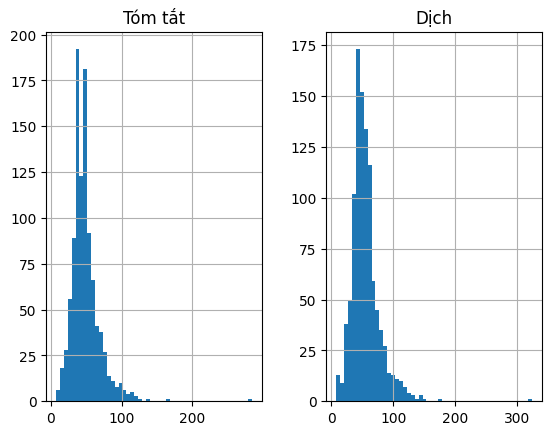

In [11]:
# Khảo sát độ dài của chuỗi đầu vào và đầu ra
highlights_word_count = []
vi_word_count = []

for i in df['highlights']:
      highlights_word_count.append(len(i.split()))

for i in df['vi']:
      vi_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Tóm tắt': highlights_word_count, 'Dịch':vi_word_count})
length_df.hist(bins = 50)
plt.show()

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
validation_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [13]:
train_dataset = Dataset.from_dict({
    "inputs": train_df["highlights"].values.tolist(),
    "targets": train_df["vi"].values.tolist()
})

test_dataset = Dataset.from_dict({
    "inputs": test_df["highlights"].values.tolist(),
    "targets": test_df["vi"].values.tolist()
})

validation_dataset = Dataset.from_dict({
    "inputs": validation_df["highlights"].values.tolist(),
    "targets": validation_df["vi"].values.tolist()
})

In [13]:
# Tạo DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "val": validation_dataset,
    "test": test_dataset
})

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 817
    })
    val: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 102
    })
    test: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 103
    })
})

---

### Model VietAI/envit5-translation

In [16]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/envit5-translation")
model = TFAutoModelForSeq2SeqLM.from_pretrained("VietAI/envit5-translation")

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at VietAI/envit5-translation.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [17]:
max_input_length = 128
max_target_length = 128
                         
def preprocess_function(examples):
    model_inputs = tokenizer( examples['inputs'],
                                max_length=max_input_length,
                                truncation=True
                            )

    labels = tokenizer( text_target=examples["targets"],
                        max_length=max_target_length,
                        truncation=True
                    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [18]:
tokenizer_data = dataset.map(preprocess_function, batched = True, remove_columns = ['inputs', 'targets'])

Map:   0%|          | 0/817 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/103 [00:00<?, ? examples/s]

In [19]:
tokenizer_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 817
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 102
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 103
    })
})

In [20]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128)

In [21]:
batch_size = 32
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [22]:
train_dataset = model.prepare_tf_dataset(
    tokenizer_data["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

val_dataset = model.prepare_tf_dataset(
    tokenizer_data["val"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

test_dataset = model.prepare_tf_dataset(
    tokenizer_data["test"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [23]:
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)
check_point = keras.callbacks.ModelCheckpoint(
    filepath='./model_translate.h5',
    monitor='loss_accuracy',
    mode='min',
    save_best_only=True)

In [24]:
model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[check_point])

Epoch 1/2
25/25 [==============================] - 4247s 169s/step - loss: 3.1128 - val_loss: 2.0784
Epoch 2/2
25/25 [==============================] - 4152s 166s/step - loss: 2.1920 - val_loss: 1.7874


In [31]:
model.save_pretrained("tf_model/")

---

### Đánh giá model

In [22]:
import sacrebleu
import numpy as np

In [15]:
test_dataset

Dataset({
    features: ['inputs', 'targets'],
    num_rows: 103
})

In [17]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/envit5-translation")
model_pretrained = TFAutoModelForSeq2SeqLM.from_pretrained("VietAI/envit5-translation")
model_finetuning = TFAutoModelForSeq2SeqLM.from_pretrained("../model/tf_model/")

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at VietAI/envit5-translation.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at D:/study/nlp/t

In [18]:
def generate_translation(model, input_text):
    input_ids = tokenizer.encode(input_text, return_tensors="tf")
    outputs = model.generate(input_ids)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

In [19]:
# Tạo danh sách đầu ra dự đoán của mô hình
predictions = [generate_translation(model_pretrained, input_text) for input_text in test_dataset["inputs"]]

# Chuyển đổi references và predictions thành định dạng phù hợp với sacrebleu
references = [[target] for target in test_dataset["targets"]]  # Mỗi reference là một list của các từ
predictions = [target for target in predictions]  # Mỗi prediction là một chuỗi

# Tính và lưu BLEU score cho từng cặp câu
bleu_model_pretrained = []
for i in range(len(predictions)):
    reference = references[i]
    prediction = predictions[i]

    # Tính BLEU score cho cặp câu hiện tại
    bleu = sacrebleu.corpus_bleu([prediction], [reference])

    # Lưu BLEU score vào danh sách
    bleu_model_pretrained.append(bleu.score)

    # In kết quả
    print(f"BLEU Score for Example {i + 1}: {bleu.score}")

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


BLEU Score for Example 1: 5.251325596616349
BLEU Score for Example 2: 0.06585560504961668
BLEU Score for Example 3: 0.008962626621970787
BLEU Score for Example 4: 0.23102943014927285
BLEU Score for Example 5: 0.3663878271670461
BLEU Score for Example 6: 2.3125177829660863
BLEU Score for Example 7: 0.21867683349848419
BLEU Score for Example 8: 0.5468482660226331
BLEU Score for Example 9: 5.7206899887723175
BLEU Score for Example 10: 1.1526963230184712
BLEU Score for Example 11: 9.529367054520856
BLEU Score for Example 12: 0.8764402403197127
BLEU Score for Example 13: 5.3235010579974364
BLEU Score for Example 14: 1.2818142001556916
BLEU Score for Example 15: 0.6852971698484914
BLEU Score for Example 16: 0.41853566905512946
BLEU Score for Example 17: 0.1904476572881443
BLEU Score for Example 18: 3.450055974355716
BLEU Score for Example 19: 0.10817062280543367
BLEU Score for Example 20: 0.0802692481879688
BLEU Score for Example 21: 0.10394226594851783
BLEU Score for Example 22: 0.382980801

In [20]:
# Tạo danh sách đầu ra dự đoán của mô hình
predictions = [generate_translation(model_finetuning, input_text) for input_text in test_dataset["inputs"]]

# Chuyển đổi references và predictions thành định dạng phù hợp với sacrebleu
references = [[target] for target in test_dataset["targets"]]  # Mỗi reference là một list của các từ
predictions = [target for target in predictions]  # Mỗi prediction là một chuỗi

# Tính và lưu BLEU score cho từng cặp câu
bleu_model_finetuning = []
for i in range(len(predictions)):
    reference = references[i]
    prediction = predictions[i]

    # Tính BLEU score cho cặp câu hiện tại
    bleu = sacrebleu.corpus_bleu([prediction], [reference])

    # Lưu BLEU score vào danh sách
    bleu_model_finetuning.append(bleu.score)

    # In kết quả
    print(f"BLEU Score for Example {i + 1}: {bleu.score}")

BLEU Score for Example 1: 5.391483981339191
BLEU Score for Example 2: 0.06509414060547228
BLEU Score for Example 3: 0.011878845454047202
BLEU Score for Example 4: 0.2408823468191835
BLEU Score for Example 5: 0.2825778303179715
BLEU Score for Example 6: 2.3125177829660863
BLEU Score for Example 7: 0.3677691307758176
BLEU Score for Example 8: 1.0548704522420085
BLEU Score for Example 9: 10.670721614580264
BLEU Score for Example 10: 1.757168251209286
BLEU Score for Example 11: 1.401483084566282
BLEU Score for Example 12: 0.9245083171968447
BLEU Score for Example 13: 4.531449772693371
BLEU Score for Example 14: 2.6861731923207386
BLEU Score for Example 15: 0.5578167280558859
BLEU Score for Example 16: 0.41853566905512946
BLEU Score for Example 17: 0.6756385622080393
BLEU Score for Example 18: 4.380961919583343
BLEU Score for Example 19: 0.10503189462498921
BLEU Score for Example 20: 0.08401261576611424
BLEU Score for Example 21: 0.07820923618967607
BLEU Score for Example 22: 0.667967945259

In [23]:
# Chuyển đổi danh sách thành mảng NumPy để thực hiện các phép toán
bleu_model_finetuning = np.array(bleu_model_finetuning)
bleu_model_pretrained = np.array(bleu_model_pretrained)

# Tính giá trị trừ
difference = bleu_model_finetuning - bleu_model_pretrained

# Đếm số lượng giá trị âm và dương
negative_values = np.sum(difference < 0)
positive_values = np.sum(difference > 0)

print("Số lượng giá trị âm:", negative_values)
print("Số lượng giá trị dương:", positive_values)

Số lượng giá trị âm: 32
Số lượng giá trị dương: 65


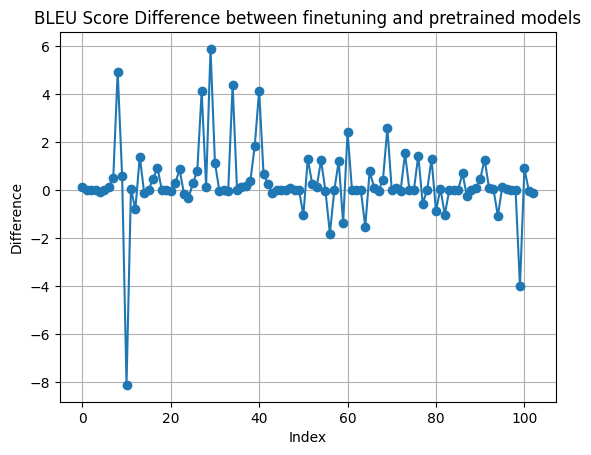

In [24]:
# Vẽ biểu đồ
plt.plot(difference, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('BLEU Score Difference between finetuning and pretrained models')
plt.grid(True)
plt.show()